In [128]:
import numpy as np

In [129]:
import matplotlib.pyplot as plt

In [130]:
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')


In [157]:
class Kalman:
    m_state = None
    m_stateTransition = None
    m_stateCovariances = None
    m_stateTransitionCovariances = None
    m_observationModel = None
    m_observationCovariances = None
    m_observationsPostFitResidual = None
    def __init__(self, num_states, num_observations):
        self.m_state = np.zeros(shape=(num_states,1))
        self.m_stateTransition = np.zeros(shape=(num_states,num_states))
        self.m_stateCovariances = np.zeros(shape=(num_states,num_states))
        self.m_stateTransitionCovariances = np.zeros(shape=(num_states,num_states))
        self.m_observationModel = np.zeros(shape=(num_observations,num_states))
        self.m_observationCovariances = np.zeros(shape=(num_observations,num_observations))
        self.m_observationsPostFitResidual = np.zeros(shape=(num_observations,1))

    
    def observe(self, observations):
        innovation = self.innovation(
            observations, 
            self.m_observationModel,
            self.m_state
        )
        innovationCovariances = self.innovationCovariances(
            self.m_observationCovariances,
            self.m_observationModel,
            self.m_stateCovariances
        )
        kalmanGain = self.kalmanGain(
            self.m_stateCovariances,
            self.m_observationModel,
            innovationCovariances
        )
        self.m_state = self.updatedState(
            self.m_state,
            kalmanGain,
            innovation
        )
        self.m_stateCovariances = self.updatedStateCovariances(
            self.m_stateCovariances,
            kalmanGain,
            innovationCovariances
        )
        self.m_observationsPostFitResidual = self.observationsPostFitResidual(
            observations,
            self.m_observationModel,
            self.m_state
        )
        
    def predict(self):
        self.m_state = self.predictState(
            self.m_stateTransition,
            self.m_state
        )
        self.m_stateCovariances = self.predictStateCovariances(
            self.m_stateTransition,
            self.m_stateCovariances,
            self.m_stateTransitionCovariances
        )
                
    def predictState(self, stateTransition, previousState):
        return stateTransition.dot(previousState)
    
    def predictStateCovariances(self, stateTransition, previousStateCovariances, stateTransitionCovariances):
        return stateTransition.dot(previousStateCovariances).dot(stateTransition.T) + stateTransitionCovariances
    
    def innovation(self, observations, observationModel, state):
        return observations - observationModel.dot(state)
    
    def innovationCovariances(self, observationCovariances, observationModel, stateCovariances):
        return observationCovariances + observationModel.dot(stateCovariances).dot(observationModel.T)
    
    def kalmanGain(self, stateCovariances, observationModel, innovationCovariances):
        invInnovationCovariances = np.linalg.inv(innovationCovariances)
        return stateCovariances.dot(observationModel.T).dot(invInnovationCovariances)
        
    def updatedState(self, previousState, kalmanGain, innovation):
        return previousState + kalmanGain.dot(innovation)
    
    def updatedStateCovariances(self, previousStateCovariances, kalmanGain, innovationCovariances):
        return previousStateCovariances - kalmanGain.dot(innovationCovariances).dot(kalmanGain.T)
    
    def observationsPostFitResidual(self, observations, observationModel, state):
        return observations - observationModel.dot(state)

In [199]:
class FirstOrderKalman(Kalman):
    m_lastTime = None
    def __init__(self, initialTime=0, initialValue=0, initialStateVariance=10, processVariance=0.1, observationVariance=1):
        super().__init__(2,1)
        self.m_lastTime = initialTime
        self.m_state[0,0] = initialValue
        self.m_stateTransition = self.stateTransition(1)
        self.m_stateCovariances = initialStateVariance * np.array([[1.0, 0.0],[0.0, 1.0]])
        self.m_stateTransitionCovariances = processVariance * np.array([[1.0, 0.0],[0.0, 1.0]])
        self.m_observationCovariances = observationVariance * np.array([[1.0]])
        self.m_observationModel = np.array([[1.0, 0.0]])
    
    def observe(self, time, observations):
            
        if self.m_lastTime is not None:
            dt = time - self.m_lastTime
            self.predict(time)
            if type(observations) != np.ndarray:
                observations = np.array([[observations]])
            super().observe(observations)

        self.m_lastTime = time
            
        return self.m_state #[0,0]
    
    def predict(self, time):
        if self.m_lastTime is not None:
            dt = time - self.m_lastTime
            self.m_stateTransition = self.stateTransition(dt)
            super().predict()
        self.m_lastTime = time
        
        return self.m_state #[0,0]
    
    def stateTransition(self, dt):
        return np.array([[1,dt],[0,1]])
    

    def print(self):
        print("m_state")
        print(self.m_state)
        print("m_stateTransition")
        print(self.m_stateTransition)
        print("m_stateCovariances")
        print(self.m_stateCovariances)
        print("m_stateTransitionCovariances")
        print(self.m_stateTransitionCovariances)
        print("m_observationModel")
        print(self.m_observationModel)
        print("m_observationCovariances")
        print(self.m_observationCovariances)
        print("m_observationsPostFitResidual")
        print(self.m_observationsPostFitResidual)

In [333]:
class SecondOrderKalman(Kalman):
    m_lastTime = None
    def __init__(self, initialTime=0, initialValue=0, initialStateVariance=10, processVariance=0.1, observationVariance=1):
        super().__init__(3,1)
        self.m_lastTime = initialTime
        self.m_state[0,0] = initialValue
        self.m_stateTransition = self.stateTransition(1)
        self.m_stateCovariances = initialStateVariance * np.identity(3)
        self.m_stateTransitionCovariances = processVariance * np.identity(3)
        self.m_observationCovariances = observationVariance * np.identity(1)
        self.m_observationModel = np.array([[1.0, 0.0, 0.0]])
    
    def observe(self, time, observations):
            
        if self.m_lastTime is not None:
            dt = time - self.m_lastTime
            self.predict(time)
            if type(observations) != np.ndarray:
                observations = np.array([[observations]])
            super().observe(observations)

        self.m_lastTime = time
            
        return self.m_state #[0,0]
    
    def predict(self, time):
        if self.m_lastTime is not None:
            dt = time - self.m_lastTime
            self.m_stateTransition = self.stateTransition(dt)
            super().predict()
        self.m_lastTime = time
        
        return self.m_state #[0,0]
    
    def stateTransition(self, dt):
        return np.array([[1,dt,dt*dt/2],[0,1,dt],[0,0,1]])
    

    def print(self):
        print("m_state")
        print(self.m_state)
        print("m_stateTransition")
        print(self.m_stateTransition)
        print("m_stateCovariances")
        print(self.m_stateCovariances)
        print("m_stateTransitionCovariances")
        print(self.m_stateTransitionCovariances)
        print("m_observationModel")
        print(self.m_observationModel)
        print("m_observationCovariances")
        print(self.m_observationCovariances)
        print("m_observationsPostFitResidual")
        print(self.m_observationsPostFitResidual)

In [116]:
foo = FirstOrderKalman()

In [117]:
foo.m_stateTransition.dot(foo.m_state)

array([[ 0.],
       [ 0.]])

In [118]:
print("m_state")
print(foo.m_state)
print("m_stateTransition")
print(foo.m_stateTransition)
print("m_stateCovariances")
print(foo.m_stateCovariances)
print("m_stateTransitionCovariances")
print(foo.m_stateTransitionCovariances)
print("m_observationModel")
print(foo.m_observationModel)
print("m_observationCovariances")
print(foo.m_observationCovariances)
print("m_observationsPostFitResidual")
print(foo.m_observationsPostFitResidual)

m_state
[[ 0.]
 [ 0.]]
m_stateTransition
[[1 1]
 [0 1]]
m_stateCovariances
[[ 10.   0.]
 [  0.  10.]]
m_stateTransitionCovariances
[[ 0.1  0. ]
 [ 0.   0.1]]
m_observationModel
[[ 1.  0.]]
m_observationCovariances
[[ 100.]]
m_observationsPostFitResidual
[[ 0.]]


In [124]:
data = list()
foo = FirstOrderKalman()
foo.m_lastTime = 0
data.append(foo.observe(0, 0))
data.append(foo.observe(1, 1))
data.append(foo.observe(2, 2))
data.append(foo.predict(3))


[[ 110.1]]
self.m_state
[[ 0.]
 [ 0.]]
kalmanGain
[[ 0.09173479]
 [ 0.        ]]
innovation
[[ 0.]]
[[ 119.37347866]]
self.m_state
[[ 0.]
 [ 0.]]
kalmanGain
[[ 0.16229299]
 [ 0.08460841]]
innovation
[[ 1.]]
[[ 142.5964356]]
self.m_state
[[ 0.2469014 ]
 [ 0.08460841]]
kalmanGain
[[ 0.2987202 ]
 [ 0.12487196]]
innovation
[[ 1.7530986]]


In [123]:
for state in data:
    print(state)

[[ 0.]
 [ 0.]]
[[ 0.16736053]
 [ 0.08326395]]
[[ 0.77457127]
 [ 0.29886288]]
[[ 1.07343415]
 [ 0.29886288]]


In [64]:
a=np.array([[1]])

In [221]:
num = 100
timespan = 3.14 * 2

In [222]:
times = (np.linspace(0,timespan,num) + np.random.uniform(0,(timespan/num),num))

In [284]:
signal = np.sin(times) + np.random.normal(0,0.1,num)

In [285]:
kalman = FirstOrderKalman(initialTime=0, initialValue=0, initialStateVariance=10, processVariance=0.1, observationVariance=0.1)

In [286]:
filtered = list()
for k,(time,value) in enumerate(zip(times,signal)):
    kalman.observe(time,value)
    filtered.append(kalman.m_state[0,0])
filtered = np.array(filtered)

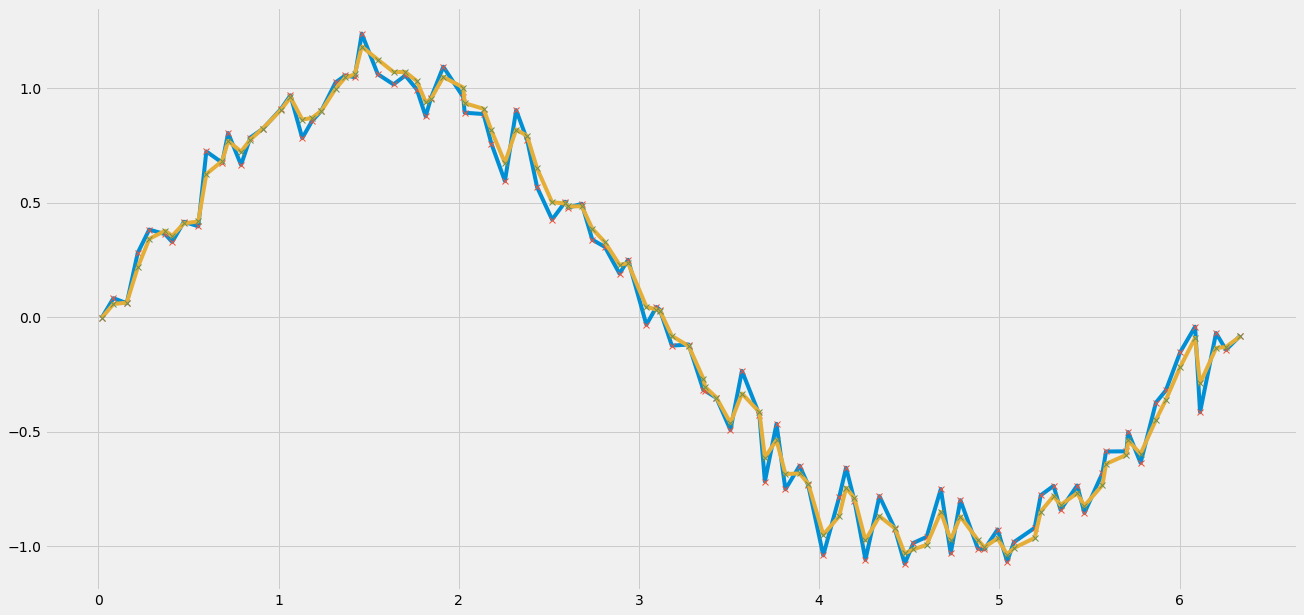

In [287]:
plt.figure(figsize=(20,10))
plt.plot(times,signal)
plt.plot(times,signal,"x")
plt.plot(times,filtered)
plt.plot(times,filtered,"x")

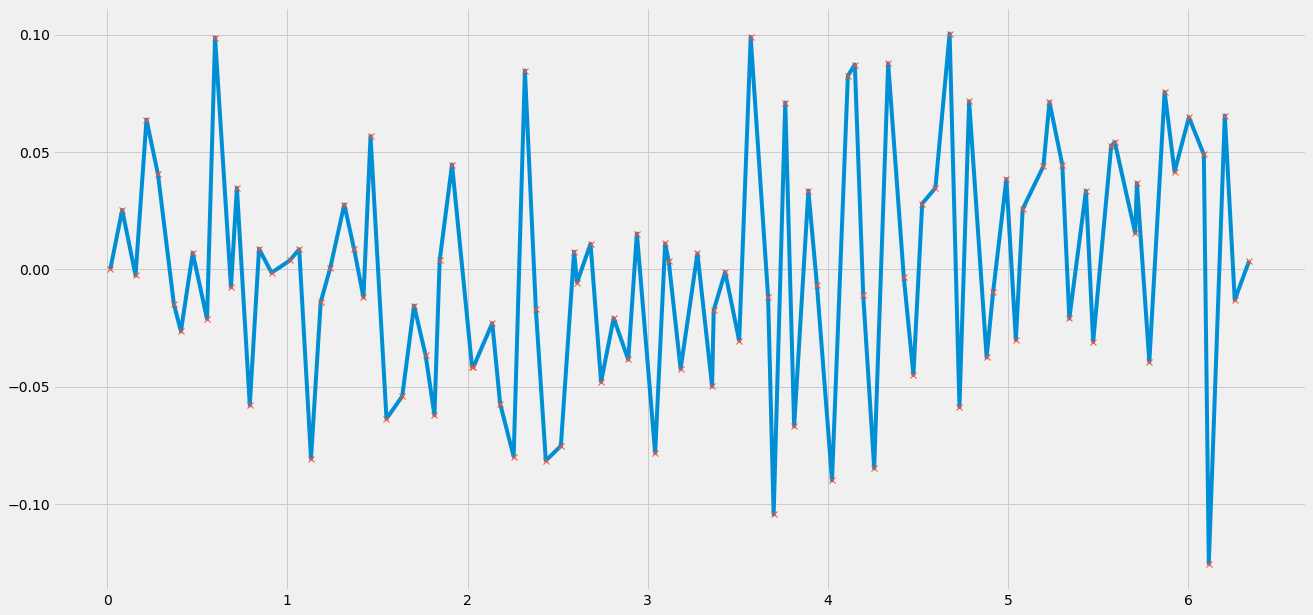

In [288]:
plt.figure(figsize=(20,10))
plt.plot(times,signal-filtered)
plt.plot(times,signal-filtered,"x")


In [289]:
smoothTimestep = (timespan/num)/4
smoothTimes = np.arange(times.min(),times.max(),smoothTimestep)

In [329]:
kalman = FirstOrderKalman(initialTime=0, initialValue=0, initialStateVariance=(10,100), processVariance=(0.1,1.5), observationVariance=0.5)
kalman.print()

m_state
[[ 0.]
 [ 0.]]
m_stateTransition
[[1 1]
 [0 1]]
m_stateCovariances
[[  10.    0.]
 [   0.  100.]]
m_stateTransitionCovariances
[[ 0.1  0. ]
 [ 0.   1.5]]
m_observationModel
[[ 1.  0.]]
m_observationCovariances
[[ 0.5]]
m_observationsPostFitResidual
[[ 0.]]


In [367]:
kalman = SecondOrderKalman(initialTime=0, initialValue=0, initialStateVariance=(10,100,100), processVariance=(0.1,1.05,0.00005), observationVariance=0.5)
kalman.print()

m_state
[[ 0.]
 [ 0.]
 [ 0.]]
m_stateTransition
[[ 1.   1.   0.5]
 [ 0.   1.   1. ]
 [ 0.   0.   1. ]]
m_stateCovariances
[[  10.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]
m_stateTransitionCovariances
[[  1.00000000e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.05000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   5.00000000e-05]]
m_observationModel
[[ 1.  0.  0.]]
m_observationCovariances
[[ 0.5]]
m_observationsPostFitResidual
[[ 0.]]


In [368]:

smoothSignal = list()
signalIdx = 0
currentTime = times.min()
while signalIdx < num and currentTime < times.max():
    if currentTime < times[signalIdx]:
        # predict
        kalman.predict(currentTime)
        pass
    elif times[signalIdx] <= currentTime:
        # observe
        kalman.observe(times[signalIdx], signal[signalIdx])
        kalman.predict(currentTime)
        signalIdx += 1
    #kalman.print()
    smoothSignal.append(kalman.m_state[0,0])
    currentTime += smoothTimestep
smoothSignal = np.array(smoothSignal)

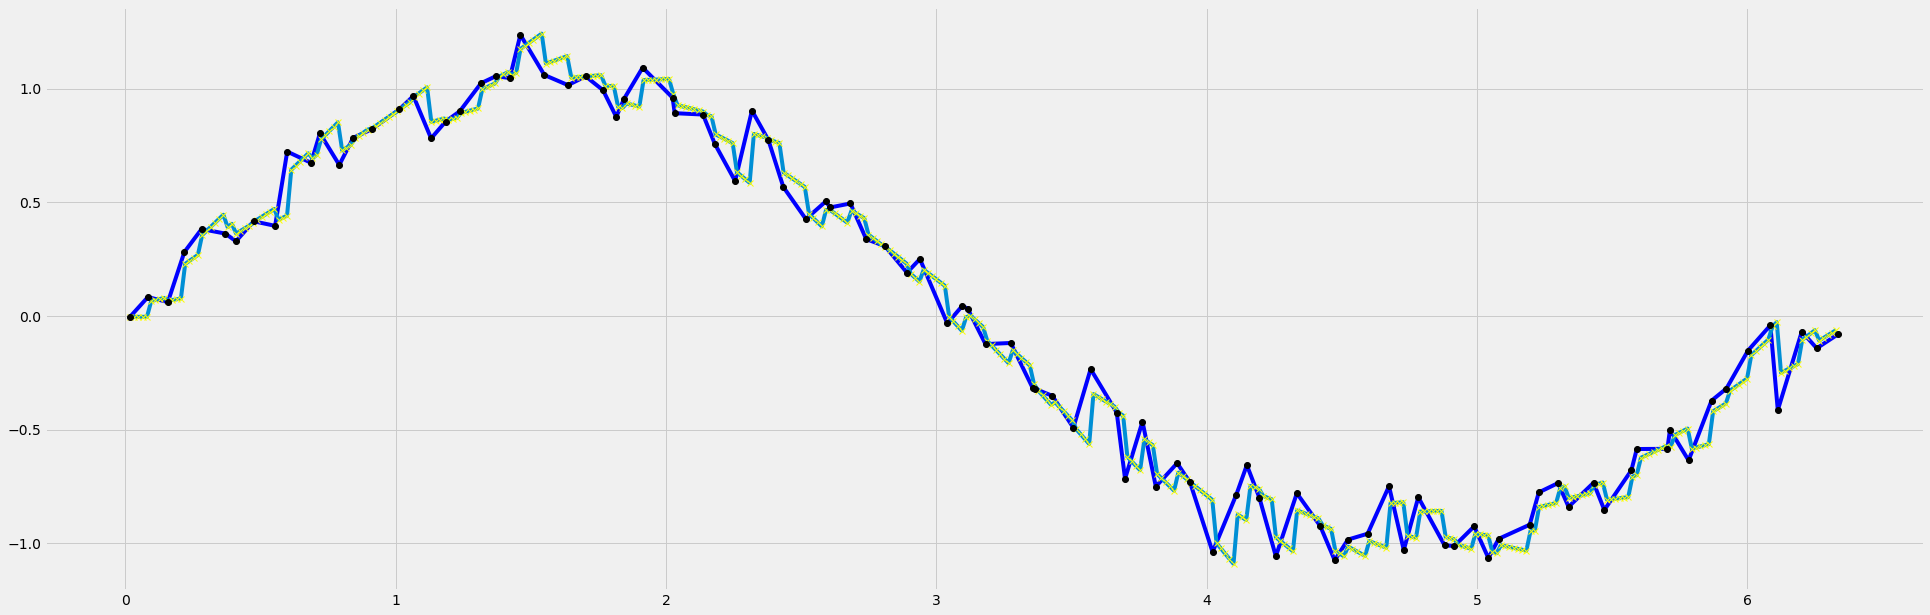

In [369]:
plt.figure(figsize=(30,10))
plt.plot(times,signal,color="blue")
plt.plot(smoothTimes,smoothSignal)
plt.plot(smoothTimes,smoothSignal,"x",color="yellow")
plt.plot(times,signal,"o",color="black")



In [328]:
dt = 0.1
decayPerTimespan = 0.125
decayTimespan = 1.0
decayPerSecond = np.exp(np.log(decayPerTimespan) / decayTimespan)
decayPerDT = np.power(decayPerSecond, dt)

In [278]:
print(decayPerTimespan)
print(decayTimespan)
print(decayPerSecond)
print(decayPerDT)

0.125
1.0
0.125
0.812252396356


In [279]:

ts = np.arange(0,decayTimespan,dt)
xs = np.zeros(shape=ts.shape)
xs[0] = 1
for k in range(1,xs.shape[0]):
    xs[k] = xs[k-1] * decayPerDT
    

(0.0, 0.90000000000000002)

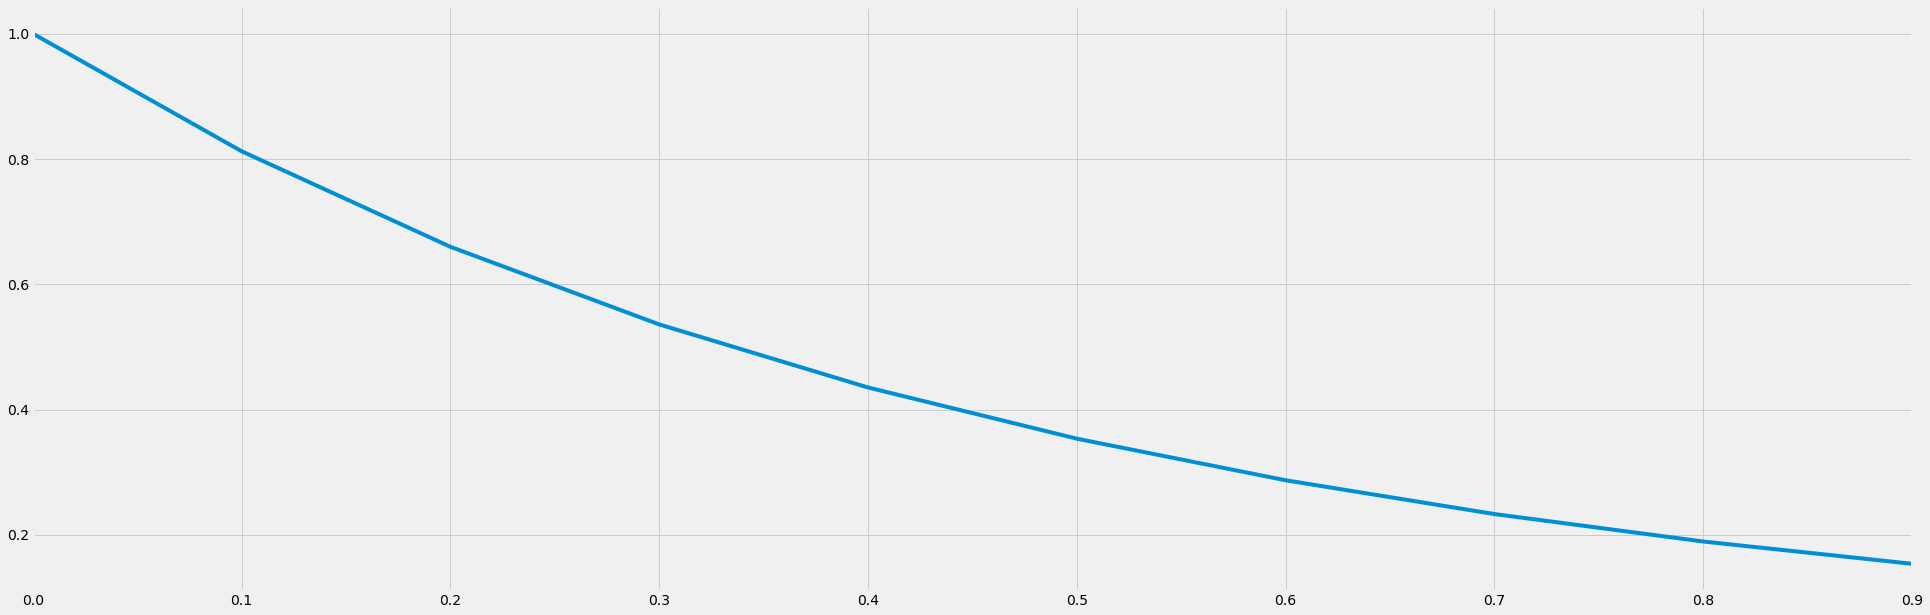

In [280]:
plt.figure(figsize=(30,10))
plt.plot(ts,xs)
plt.xlim(ts.min(),ts.max())

In [282]:
xs[-1]*decayPerDT

0.12500000000000011

In [283]:
0 ** 1

0

In [332]:
np.identity(3)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])